## Phân Tích Dữ Liệu MovieLens 1M: Rating Theo Giới Tính, Độ Tuổi và Thể Loại

### Import pandas để xử lý dữ liệu, numpy cho tính toán, seaborn/matplotlib để visualize.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### ĐỌC DỮ LIỆU TỪ 3 FILES

In [2]:
unames = ["user_id", "gender", "age", "occupation", "zip"]
users = pd.read_table("datasets/movielens/users.dat", sep="::", header=None, names=unames, engine="python")

rnames = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_table("datasets/movielens/ratings.dat", sep="::", header=None, names=rnames, engine="python")

mnames = ["movie_id", "title", "genres"]
movies = pd.read_table("datasets/movielens/movies.dat", sep="::", header=None, names=mnames, engine="python")

### # Kiểm tra dữ liệu đầu vào

In [3]:
# Giải thích: In head(5) và shape để xem cấu trúc. Users: ~6040, Ratings: 1M rows, Movies: ~3883 films.
print("Users head:\n", users.head(5))
print("Ratings head:\n", ratings.head(5))
print("Movies head:\n", movies.head(5))
print("Ratings shape:", ratings.shape)  # (1000209, 4)

Users head:
    user_id gender  age  occupation    zip
0        1      F    1          10  48067
1        2      M   56          16  70072
2        3      M   25          15  55117
3        4      M   45           7  02460
4        5      M   25          20  55455
Ratings head:
    user_id  movie_id  rating  timestamp
0        1      1193       5  978300760
1        1       661       3  978302109
2        1       914       3  978301968
3        1      3408       4  978300275
4        1      2355       5  978824291
Movies head:
    movie_id                               title                        genres
0         1                    Toy Story (1995)   Animation|Children's|Comedy
1         2                      Jumanji (1995)  Adventure|Children's|Fantasy
2         3             Grumpier Old Men (1995)                Comedy|Romance
3         4            Waiting to Exhale (1995)                  Comedy|Drama
4         5  Father of the Bride Part II (1995)                        Comed

### MERGE DỮ LIỆU THÀNH SINGLE DATAFRAME

In [4]:
# Giải thích: Merge ratings với users trên user_id, rồi merge với movies trên movie_id. Kết quả: 1M rows x 10 cols.
data = pd.merge(pd.merge(ratings, users), movies)
print("Data shape after merge:", data.shape)  # (1000209, 10)
print("Sample row:\n", data.iloc[0])

Data shape after merge: (1000209, 10)
Sample row:
 user_id                                            1
movie_id                                        1193
rating                                             5
timestamp                                  978300760
gender                                             F
age                                                1
occupation                                        10
zip                                            48067
title         One Flew Over the Cuckoo's Nest (1975)
genres                                         Drama
Name: 0, dtype: object


### TÍNH MEAN RATINGS THEO GENDER

In [5]:
# Giải thích: pivot_table tính mean rating, index='title', columns='gender'. Kết quả: Mean F/M ratings per movie.
mean_ratings = data.pivot_table("rating", index="title", columns="gender", aggfunc="mean")
print("Mean ratings head:\n", mean_ratings.head(5))

Mean ratings head:
 gender                                F         M
title                                            
$1,000,000 Duck (1971)         3.375000  2.761905
'Night Mother (1986)           3.388889  3.352941
'Til There Was You (1997)      2.675676  2.733333
'burbs, The (1989)             2.793478  2.962085
...And Justice for All (1979)  3.828571  3.689024


### FILTER MOVIES PHỔ BIẾN (>=250 RATINGS)

In [7]:
# Giải thích: Groupby title đếm ratings, lọc >=250 để giảm noise. Loc mean_ratings để giữ active titles.
ratings_by_title = data.groupby("title").size()
active_titles = ratings_by_title.index[ratings_by_title >= 250]
print("Number of active titles:", len(active_titles))  # 1216
mean_ratings = mean_ratings.loc[active_titles]
print("Filtered mean ratings head:\n", mean_ratings.head())

Number of active titles: 1216
Filtered mean ratings head:
 gender                                    F         M
title                                                
'burbs, The (1989)                 2.793478  2.962085
10 Things I Hate About You (1999)  3.646552  3.311966
101 Dalmatians (1961)              3.791444  3.500000
101 Dalmatians (1996)              3.240000  2.911215
12 Angry Men (1957)                4.184397  4.328421


### TOP FILMS CHO FEMALE VIEWERS

In [8]:
# Giải thích: Sort theo 'F' descending để tìm phim nữ thích nhất (animation/drama).
top_female_ratings = mean_ratings.sort_values("F", ascending=False)
print("Top female ratings head:\n", top_female_ratings.head(10))


Top female ratings head:
 gender                                                     F         M
title                                                                 
Close Shave, A (1995)                               4.644444  4.473795
Wrong Trousers, The (1993)                          4.588235  4.478261
Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)       4.572650  4.464589
Wallace & Gromit: The Best of Aardman Animation...  4.563107  4.385075
Schindler's List (1993)                             4.562602  4.491415
Shawshank Redemption, The (1994)                    4.539075  4.560625
Grand Day Out, A (1992)                             4.537879  4.293255
To Kill a Mockingbird (1962)                        4.536667  4.372611
Creature Comforts (1990)                            4.513889  4.272277
Usual Suspects, The (1995)                          4.513317  4.518248


### Visualize top female (barh plot)

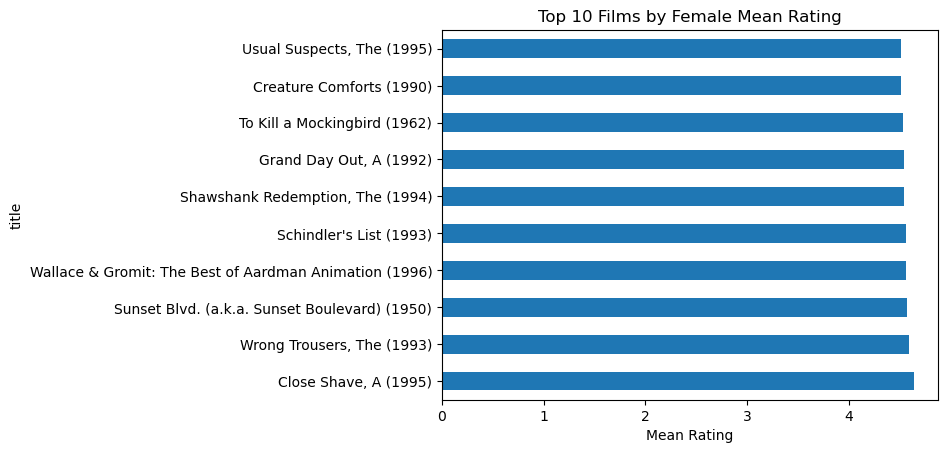

In [9]:
# Giải thích: Barh plot top 10 phim nữ rate cao, minh họa trực quan.
top_female_ratings.head(10)["F"].plot(kind='barh', title='Top 10 Films by Female Mean Rating')
plt.xlabel('Mean Rating')
plt.show()

### DISAGREEMENT GIỮA GENDER (DIFF M - F)

In [10]:
# Giải thích: Tính diff = M - F, sort để tìm phim nữ/nam prefer hơn (âm/dương).
mean_ratings["diff"] = mean_ratings["M"] - mean_ratings["F"]
sorted_by_diff_women = mean_ratings.sort_values("diff").head(10)  # Nữ prefer
print("Movies women prefer (diff head):\n", sorted_by_diff_women)
sorted_by_diff_men = mean_ratings.sort_values("diff", ascending=False).head(10)  # Nam prefer
print("Movies men prefer (diff head):\n", sorted_by_diff_men)

Movies women prefer (diff head):
 gender                                        F         M      diff
title                                                              
Dirty Dancing (1987)                   3.790378  2.959596 -0.830782
Jumpin' Jack Flash (1986)              3.254717  2.578358 -0.676359
Grease (1978)                          3.975265  3.367041 -0.608224
Little Women (1994)                    3.870588  3.321739 -0.548849
Steel Magnolias (1989)                 3.901734  3.365957 -0.535777
Anastasia (1997)                       3.800000  3.281609 -0.518391
Rocky Horror Picture Show, The (1975)  3.673016  3.160131 -0.512885
Color Purple, The (1985)               4.158192  3.659341 -0.498851
Age of Innocence, The (1993)           3.827068  3.339506 -0.487561
Free Willy (1993)                      2.921348  2.438776 -0.482573
Movies men prefer (diff head):
 gender                                         F         M      diff
title                                            

### Histogram diff

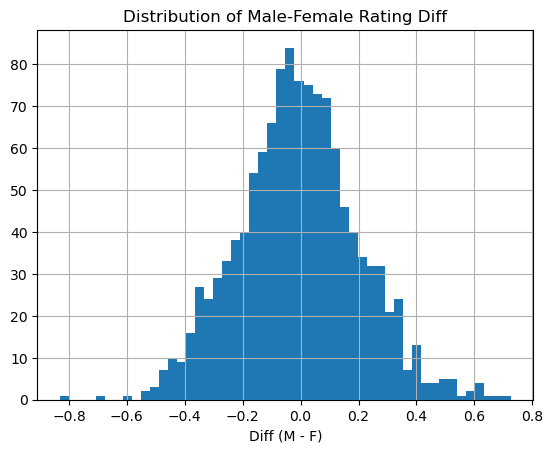

In [11]:
# Giải thích: Visualize phân phối diff để thấy mức độ disagreement. Dùng plt.title() để tránh lỗi 'title' kwarg.
mean_ratings["diff"].hist(bins=50)
plt.title('Distribution of Male-Female Rating Diff')
plt.xlabel('Diff (M - F)')
plt.show()


### DISAGREEMENT TỔNG THỂ (STD DEV RATINGS)

In [12]:
# Giải thích: Tính std rating per title, lọc active_titles, sort top 10 divisive (high std = polarizing).
rating_std_by_title = data.groupby("title")["rating"].std()
rating_std_by_title = rating_std_by_title.loc[active_titles]
print("Top divisive movies (std head):\n", rating_std_by_title.sort_values(ascending=False)[:10])

Top divisive movies (std head):
 title
Dumb & Dumber (1994)                     1.321333
Blair Witch Project, The (1999)          1.316368
Natural Born Killers (1994)              1.307198
Tank Girl (1995)                         1.277695
Rocky Horror Picture Show, The (1975)    1.260177
Eyes Wide Shut (1999)                    1.259624
Evita (1996)                             1.253631
Billy Madison (1995)                     1.249970
Fear and Loathing in Las Vegas (1998)    1.246408
Bicentennial Man (1999)                  1.245533
Name: rating, dtype: float64


### PHÂN TÍCH THEO GENRE (EXPLODE MULTI-GENRES)

In [13]:
# Giải thích: Split genres thành list, explode thành rows riêng. Merge và groupby genre/age tính mean rating.
movies["genre"] = movies["genres"].str.split("|")
movies_exploded = movies.explode("genre")
ratings_with_genre = pd.merge(pd.merge(movies_exploded, ratings), users)
genre_ratings = (ratings_with_genre.groupby(["genre", "age"])["rating"].mean().unstack("age"))
print("Genre ratings by age:\n", genre_ratings.head(10))

Genre ratings by age:
 age                1         18        25        35        45        50  \
genre                                                                     
Action       3.506385  3.447097  3.453358  3.538107  3.528543  3.611333   
Adventure    3.449975  3.408525  3.443163  3.515291  3.528963  3.628163   
Animation    3.476113  3.624014  3.701228  3.740545  3.734856  3.780020   
Children's   3.241642  3.294257  3.426873  3.518423  3.527593  3.556555   
Comedy       3.497491  3.460417  3.490385  3.561984  3.591789  3.646868   
Crime        3.710170  3.668054  3.680321  3.733736  3.750661  3.810688   
Documentary  3.730769  3.865865  3.946690  3.953747  3.966521  3.908108   
Drama        3.794735  3.721930  3.726428  3.782512  3.784356  3.878415   
Fantasy      3.317647  3.353778  3.452484  3.482301  3.532468  3.581570   
Film-Noir    4.145455  3.997368  4.058725  4.064910  4.105376  4.175401   

age                56  
genre                  
Action       3.610709  
Adve

# Heatmap visualize genre-age 

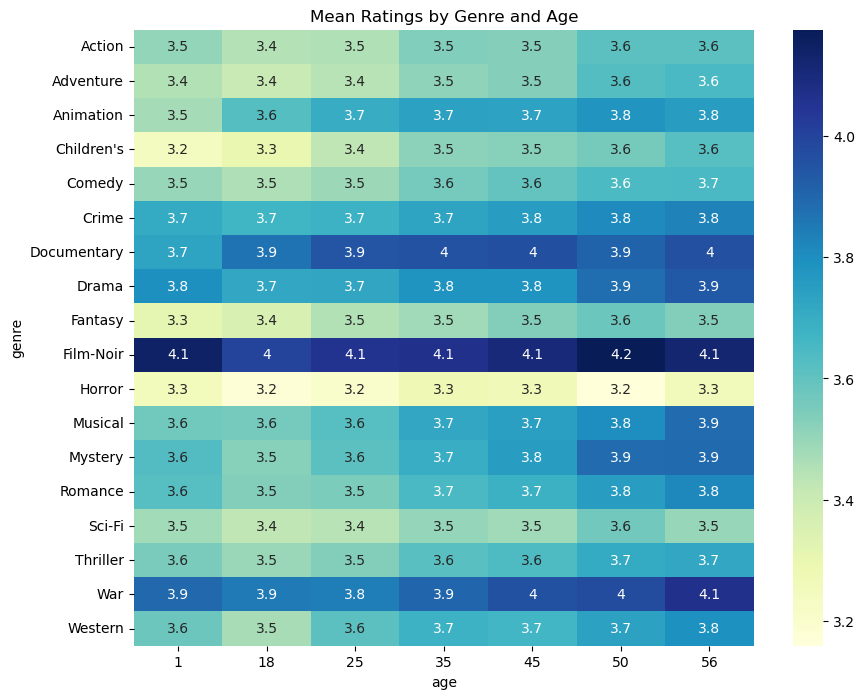

In [14]:
# Giải thích: Heatmap cho thấy trend rating theo genre/age (e.g., Film-Noir cao, Children's thấp).
plt.figure(figsize=(10, 8))
sns.heatmap(genre_ratings, annot=True, cmap="YlGnBu")
plt.title('Mean Ratings by Genre and Age')
plt.show()